In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Preprocessing and feature engineering

In [ ]:
import os
import pandas as pd
from sklearn import preprocessing
from dateutil import parser
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Custom date parser
def custom_date_parser(date):
    try:
        return pd.to_datetime(date, format='%d/%m/%Y %I:%M %p (UTC%z)', utc=True)
    except ValueError:
        # This will handle the second date format if the first one fails
        return pd.to_datetime(parser.parse(date), utc=True)

def preprocess_data(directory):
    """
    This function reads all csv files from a given directory, performs necessary pre-processing, and
    returns features and target in a normalized form.
    """
    dfs = []

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            # Convert 'Tune Date' into datetime format considering both date formats
            df['Tune Date'] = df['Tune Date'].apply(custom_date_parser)

            # Perform required transformations

            df['EM Volt Change'] = df['EM Volts'].diff()
            df['EM Volt Change'] = df['EM Volt Change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
            df['502/69'] = df['502 m/z'] / df['69 m/z']

            # Initialize the MinMaxScaler
            scaler = MinMaxScaler()

            # Reshape the column to a 2-dimensional array (required by MinMaxScaler)
            scaled_column = df['EM Volts'].values.reshape(-1, 1)

            # Perform Min-Max scaling on the column
            df['EM Volts'] = scaler.fit_transform(scaled_column)

            dfs.append(df)

    # Concatenate all DataFrames
    df = pd.concat(dfs, ignore_index=True)

    # Sort DataFrame by 'System' and 'Tune Date'
    df.sort_values(by=['System', 'Tune Date'], inplace=True)

    # Calculate time in seconds from the first record for each 'System'
    df['Time'] = df.groupby('System')['Tune Date'].transform(lambda x: (x - x.min()).dt.total_seconds())

    df['EM Volts Diff'] = df.groupby('System')['EM Volts'].diff()
    df['Time Diff'] = df.groupby('System')['Time'].diff()

    # Create 'EMV over time' as the rate of change of 'EM Volts' with respect to 'Time'
    df['EMV over time'] = df['EM Volts Diff'] / df['Time Diff']

    df['EMV over time'].fillna(0, inplace=True)

    df.drop(['EM Volts Diff', 'Time Diff'], axis=1, inplace=True)

    # Drop unnecessary columns
    df = df.drop(['Test ID', 'ID', 'Temp', 'Tune Date', '70 m/z', '220 m/z', '503 m/z', 'Filament'], axis=1)

    # Define target
    y = df['Condition']

    # Drop target column from the dataframe
    df = df.drop('Condition', axis=1)

    # Normalize the DataFrame
    scaler = preprocessing.StandardScaler().fit(df)
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    return df_scaled, y

def preprocess_data_test(directory):
    """
    This function is identical to above, but doesn't drop 'Filament' as it is not in the test dataset.
    """
    dfs = []

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)

            # Convert 'Tune Date' into datetime format considering both date formats
            df['Tune Date'] = df['Tune Date'].apply(custom_date_parser)

            # Perform required transformations

            df['EM Volt Change'] = df['EM Volts'].diff()
            df['EM Volt Change'] = df['EM Volt Change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
            df['502/69'] = df['502 m/z'] / df['69 m/z']

            # Initialize the MinMaxScaler
            scaler = MinMaxScaler()

            # Reshape the column to a 2-dimensional array (required by MinMaxScaler)
            scaled_column = df['EM Volts'].values.reshape(-1, 1)

            # Perform Min-Max scaling on the column
            df['EM Volts'] = scaler.fit_transform(scaled_column)

            dfs.append(df)

    # Concatenate all DataFrames
    df = pd.concat(dfs, ignore_index=True)

    # Sort DataFrame by 'System' and 'Tune Date'
    df.sort_values(by=['System', 'Tune Date'], inplace=True)

    # Calculate time in seconds from the first record for each 'System'
    df['Time'] = df.groupby('System')['Tune Date'].transform(lambda x: (x - x.min()).dt.total_seconds())

    df['EM Volts Diff'] = df.groupby('System')['EM Volts'].diff()
    df['Time Diff'] = df.groupby('System')['Time'].diff()

    # Create 'EMV over time' as the rate of change of 'EM Volts' with respect to 'Time'
    df['EMV over time'] = df['EM Volts Diff'] / df['Time Diff']

    df['EMV over time'].fillna(0, inplace=True)

    df.drop(['EM Volts Diff', 'Time Diff'], axis=1, inplace=True)

    # Drop unnecessary columns
    df = df.drop(['Test ID', 'ID', 'Temp', 'Tune Date', '70 m/z', '220 m/z', '503 m/z'], axis=1)

    # Define target
    y = df['Condition']

    # Drop target column from the dataframe
    df = df.drop('Condition', axis=1)

    # Normalize the DataFrame
    scaler = preprocessing.StandardScaler().fit(df)
    df_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    return df_scaled, y

In [ ]:
X_train, y_train = preprocess_data('/content/drive/Shareddrives/AI-Hackathon/Data/UTS-AI-Hackathon-main/Data/train')
X_test, y_test = preprocess_data('/content/drive/Shareddrives/AI-Hackathon/Data/UTS-AI-Hackathon-main/Data/validation')
X_test1, y_test1 = preprocess_data_test('/content/drive/Shareddrives/AI-Hackathon/Data/UTS-AI-Hackathon-main/Data/test')

In [ ]:
X_train.to_csv('X_train.csv', index = False)

# Train SVM as an exemplar

In [ ]:
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report

# Initialize SVM classifier
clf = svm.SVC(kernel='linear', class_weight='balanced')

# Fit data
clf = clf.fit(X_train, y_train)

# Predict the test data
y_pred = clf.predict(X_test)

# Print classification report
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

# Compare Model Performance

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

classifiers = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=42)),
    ('Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Balanced Bagging', BalancedBaggingClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(class_weight='balanced', random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42, scale_pos_weight=sum(y_train==0)/sum(y_train==1))),
    ('SVM', make_pipeline(StandardScaler(), SVC(class_weight='balanced', random_state=42)))
]

# Iterate over the classifiers
for clf_name, clf in classifiers:
    # Fit the classifier on the training set
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Compute evaluation metrics on the test set
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print the classifier and the performance metrics
    print(f'{clf_name}:')
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC: {roc_auc}")
    print(f"F1-score: {f1}")
    print("\n")

Logistic Regression:
Accuracy: 0.553072625698324
Precision: 0.04878048780487805
Recall: 0.6666666666666666
ROC AUC: 0.6078998073217725
F1-score: 0.0909090909090909




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest:
Accuracy: 0.9664804469273743
Precision: 0.0
Recall: 0.0
ROC AUC: 0.5
F1-score: 0.0


Gradient Boosting:
Accuracy: 0.9441340782122905
Precision: 0.0
Recall: 0.0
ROC AUC: 0.4884393063583815
F1-score: 0.0


Balanced Bagging:
Accuracy: 0.6033519553072626
Precision: 0.028985507246376812
Recall: 0.3333333333333333
ROC AUC: 0.4730250481695568
F1-score: 0.05333333333333333


Decision Tree:
Accuracy: 0.8156424581005587
Precision: 0.034482758620689655
Recall: 0.16666666666666666
ROC AUC: 0.5024084778420038
F1-score: 0.05714285714285715


XGBoost:
Accuracy: 0.8938547486033519
Precision: 0.06666666666666667
Recall: 0.16666666666666666
ROC AUC: 0.5428709055876686
F1-score: 0.09523809523809522


SVM:
Accuracy: 0.7486033519553073
Precision: 0.10204081632653061
Recall: 0.8333333333333334
ROC AUC: 0.7894990366088632
F1-score: 0.18181818181818182




# CM for best performing classifier (SVM)

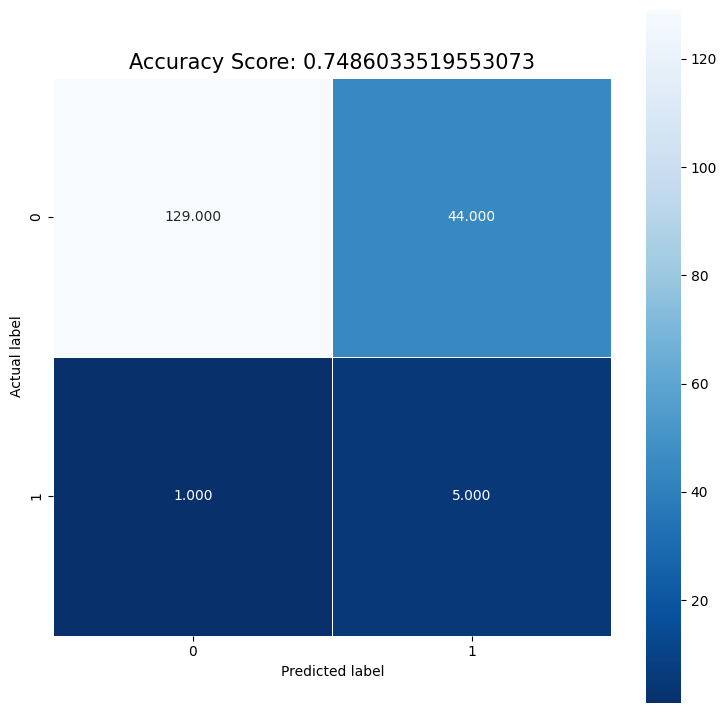

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size=15)
plt.show()

# Save predictions and probabilities on the validation set

In [ ]:
decision_scores = clf.decision_function(X_test)

# Create a DataFrame with the actual labels, predicted labels, and decision scores
predictions_df = pd.DataFrame({'Actual Label': y_test,
                                       'Predicted Label': y_pred,
                                       'Decision Score': decision_scores})

# Save the DataFrame to a CSV file
predictions_df.to_csv('svm_prob_predictions.csv', index=False)

# Predictions on test dataset

In [ ]:
import pandas as pd

# Use the trained SVM classifier to make predictions on the new test data
if clf_name == 'SVM':
  y_pred_score = clf.decision_function(X_test1)
  y_pred_proba = expit(y_pred_score)  # squash scores to [0, 1] with sigmoid function
  y_pred = (y_pred_proba >= threshold).astype('int')

# Save the predictions to a new CSV file
predictions = pd.DataFrame(y_pred, columns=['Condition'])
predictions.to_csv('predictions_test.csv', index=True)